# SIMEX notebook for CRL focussing.

In this example, we add a focussing element to our beamline, a *Compound Refractive Lense* stack, or CRL. A CRL is a group of lenses stacked along the beam direction. 
Since the refractive index of most materials in the x-ray regime is close to $n=1$, multiple lenses have to be stacked to achieve a relatively short focal length $f$.

A schematic drawing of a single lense and a CRL is given in the figure below (credits: http://www.x-ray-optics.de/index.php/en/types-of-optics/refractive-lenses, accessed on Oct. 13 2021):  
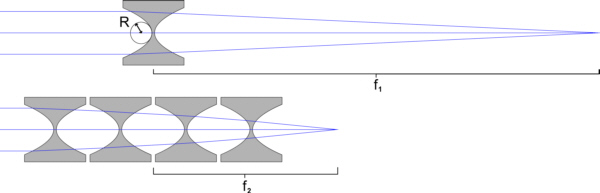

The CRL lense can be made from various materials, here we us Beryllium. We will need the refractive index of Beryllium at our chosen photon energy. These material x-ray properties can be looked up at the website https://henke.lbl.gov/optical_constants/getdb2.html or programmatically using the python `xraydb` library.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters
from SimEx.Analysis.XFELPhotonAnalysis import XFELPhotonAnalysis

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy
import copy
import xraydb

from IPython.display import Markdown as md

### Setup the initial wavefront
We first create a wavefront at $z=100$ m downstream from the source. The intensity distribution in $x$, $y$, and $t$ is assumed to be Gaussian. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`.

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [3]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=30,
                                                z = 100*meter
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [4]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [5]:
photon_source.backengine()

#### Save wavefront data for later re-use

In [6]:
photon_source.saveH5()

### Creata analysis object and generate some plots

In [7]:
analysis = XFELPhotonAnalysis('initial_wavefront.h5')


 Start initialization.

 Loading wavefront from initial_wavefront.h5.
 ... done.

 Getting intensities.
 ... done.
 Data dimensions =  (400, 400, 30)

 Masking NANs.
 ... done.


#### Intensity map


 Plotting intensity map.
R-space


<Figure size 432x288 with 0 Axes>

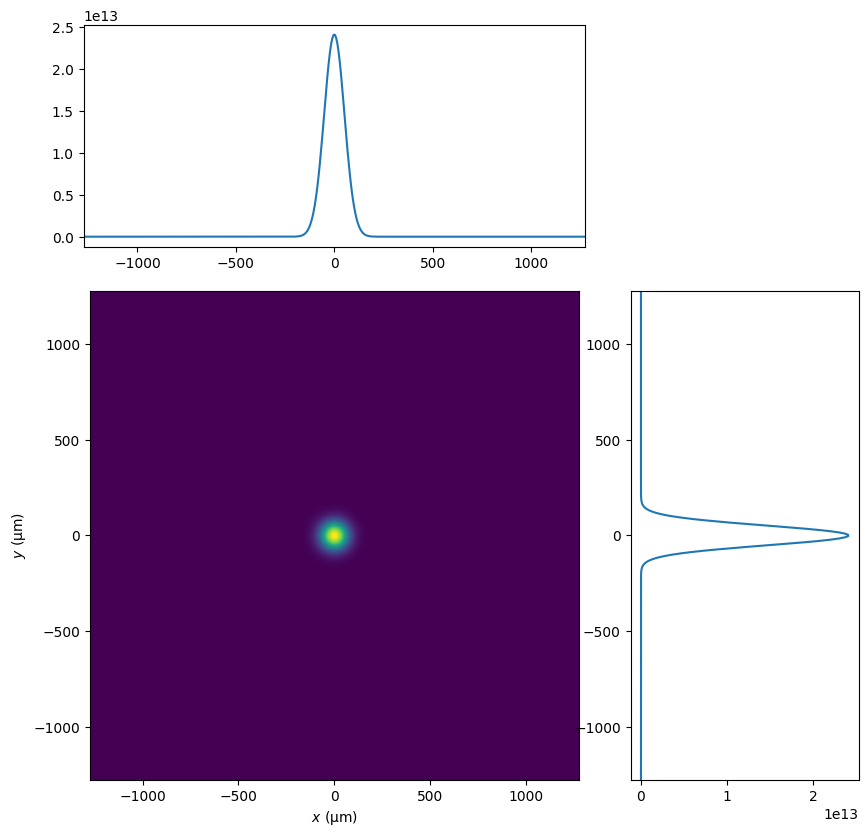

In [8]:
analysis.plotIntensityMap()

#### On-axis power density as function of time


 Plotting on-axis power density.


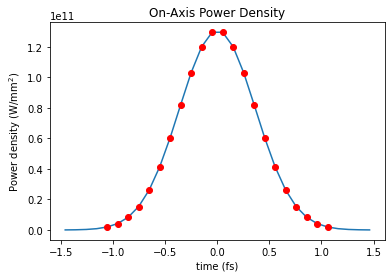

In [9]:
analysis.plotOnAxisPowerDensity()

## Plot intensity distribution in q-space


 Plotting intensity map.

 Switching to reciprocal space.
 ... done.
Q-space


<Figure size 432x288 with 0 Axes>

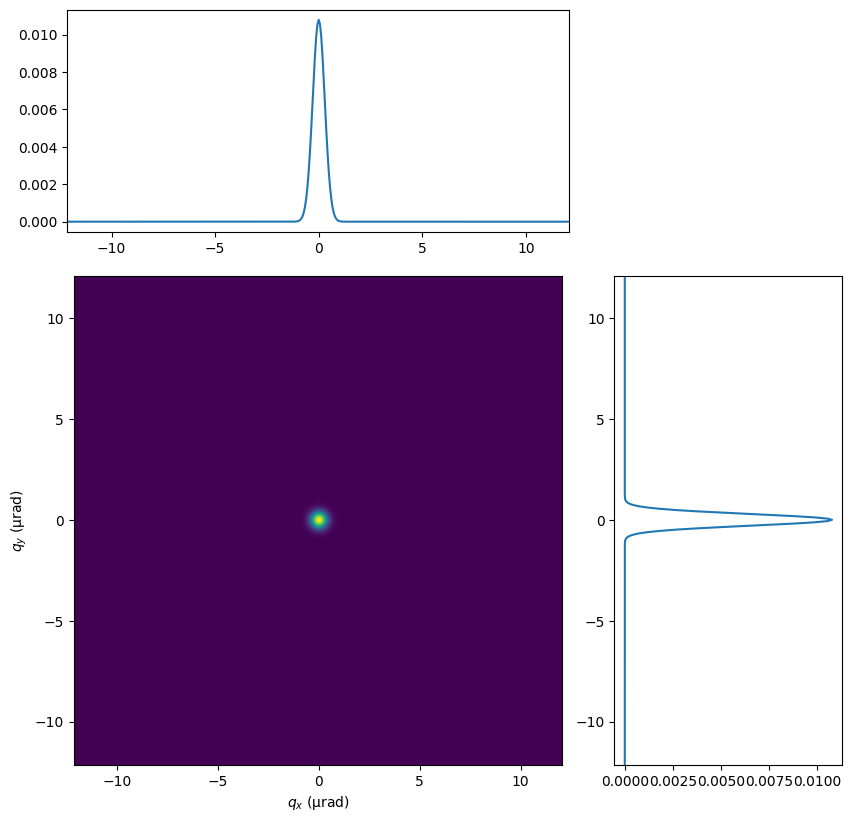

In [10]:
analysis.plotIntensityMap(qspace=True)

Plot the power as a function of time integrated over the transverse dimensions


 Plotting total power.
Pulse energy 2e-06 J


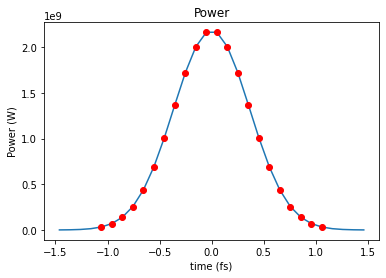

In [11]:
analysis.plotTotalPower()

Plot the power spectrum


 Plotting total power.

 Switching to frequency domain.


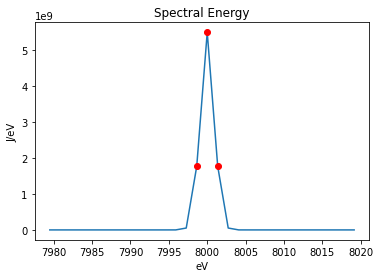

In [12]:
analysis.plotTotalPower(spectrum=True)

In [13]:
import wpg
from wpg import wpg_uti_wf as wpg_utils
from wpg import wpg_uti_oe as optics_utils

In [14]:
wavefront = copy.deepcopy(photon_source.data)

Check the sampling quality

In [15]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
|Vertical  |1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


## Setup the beamline
Our experiment consists of
* The photon source at the origin
* 100 m of free space (already taken into account in the wavefront construction).
* The CRL
* Another distance of free space
* The detector (screen)

The goal of this exercise is to minimize the size of the beam by varying the final screen position along the beam direction.

In [16]:
from wpg import Beamline, optical_elements, srwlib
from wpg.useful_code.wfrutils import propagate_wavefront

In [17]:
beamline = Beamline()

## Setting up the CRL
We employ the `CRL` class in `wpg.optical_elements`. 

In [18]:
optical_elements.CRL?

Signature:
optical_elements.CRL(
    _foc_plane,
    _delta,
    _atten_len,
    _shape,
    _apert_h,
    _apert_v,
    _r_min,
    _n,
    _wall_thick,
    _xc,
    _yc,
    _void_cen_rad=None,
    _e_start=0,
    _e_fin=0,
    _nx=1001,
    _ny=1001,
)
Docstring:
Setup Transmission type Optical Element which simulates Compound Refractive Lens (CRL).

:param _foc_plane: plane of focusing: 1- horizontal, 2- vertical, 3- both
:param _delta: refractive index decrement (can be one number of array vs photon energy)
:param _atten_len: attenuation length [m] (can be one number of array vs photon energy)
:param _shape: 1- parabolic, 2- circular (spherical)
:param _apert_h: horizontal aperture size [m]
:param _apert_v: vertical aperture size [m]
:param _r_min: radius (on tip of parabola for parabolic shape) [m]
:param _n: number of lenses (/"holes")
:param _wall_thick: min. wall thickness between "holes" [m]
:param _xc: horizontal coordinate of center [m]
:param _yc: vertical coordinate of ce

We set up a circular (`shape='c'`) obstacle (`ap_or_ob = 'ob'`) of radius $100$ nm in both and place it at the beam center
$x_\text{center} = y_\text{center} = 0$ (`x=0`, `y=0`).

### Get the components of the refractive index for Be (solid Be density is 1.85 g/ccm)

In [19]:
delta, beta, att = xraydb.xray_delta_beta("Be", density=1.85, energy=photon_source.parameters.photon_energy.m_as(electronvolt))

In [20]:
delta, beta, att

(5.3304712513701975e-06, 2.0760166538592506e-09, 0.594067304452888)

In [21]:
crl = optical_elements.CRL(
    _foc_plane=3,
    _delta=delta,
    _atten_len=att*1e-2,
    _shape=1,
    _apert_h=5.0e-3,
    _apert_v=5.0e-3,
    _r_min=5.8e-3,
    _n=20,
    _wall_thick=8.0e-5,
    _xc=0.0,
    _yc=0.0,
    _void_cen_rad=None,
    _e_start=0,
    _e_fin=0,
    _nx=1001,
    _ny=1001,
)

Optical Element Setup: CRL Focal Length: 27.202097743745966 m


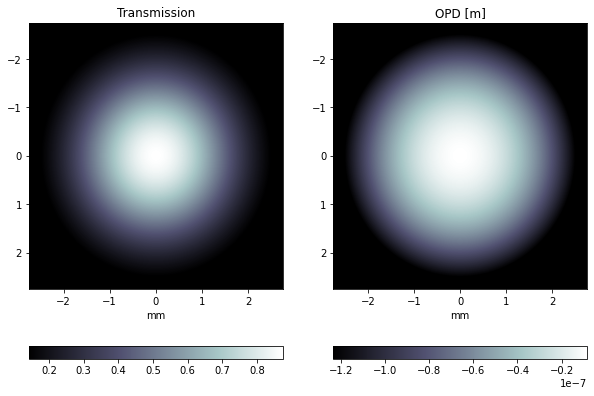

In [22]:
optics_utils.show_transmission(crl)

In [23]:
crl_pp = optical_elements.Use_PP(semi_analytical_treatment=1,
                                    zoom=1,
                                    sampling=1
                                   )

In [24]:
beamline.append(crl, crl_pp)

In [25]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
propagate_wavefront(wavefront,beamline)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 27.202097743745966
	Fy = 27.202097743745966
	arTr = array of size 2004002
	extTr = 1
	input_parms = {'type': 'crl', 'focalPlane': 3, 'refractiveIndex': 5.3304712513701975e-06, 'attenuationLength': 0.00594067304452888, 'shape': 1, 'horizontalApertureSize': 0.005, 'verticalApertureSize': 0.005, 'radius': 0.0058, 'numberOfLenses': 20, 'wallThickness': 8e-05, 'horizontalCenterCoordinate': 0.0, 'verticalCenterCoordinate': 0.0, 'voidCenterCoordinates': None, 'initialPhotonEnergy': 0, 'finalPhotonPnergy': 0, 'horizontalPoints': 1001, 'verticalPoints': 1001}
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1001
		ny = 1001
		xFin = 0.0027500000000000003
		xStart = -0.0027500000000000003
		yFin = 0.0027500000000000003
		yStart = -0.0027500000000000003
		zStart = 0
	
	

R-space
nx   400

R-space
(400,) (400,)
FWHM in x = 1.147e-04 m.
FWHM in y = 1.147e-04 m.


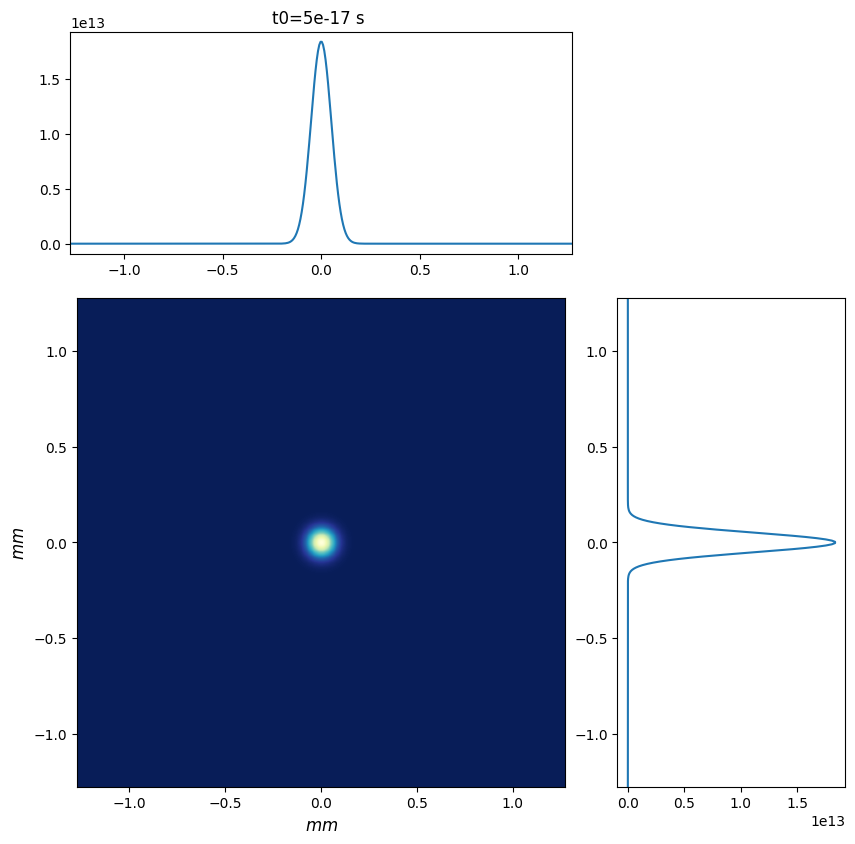

In [26]:
wpg_utils.plot_intensity_map(wavefront)

Q-space
{'fwhm_x': 4.054793392122859e-06, 'fwhm_y': 4.054793392122859e-06}
Q-space
(400,) (400,)


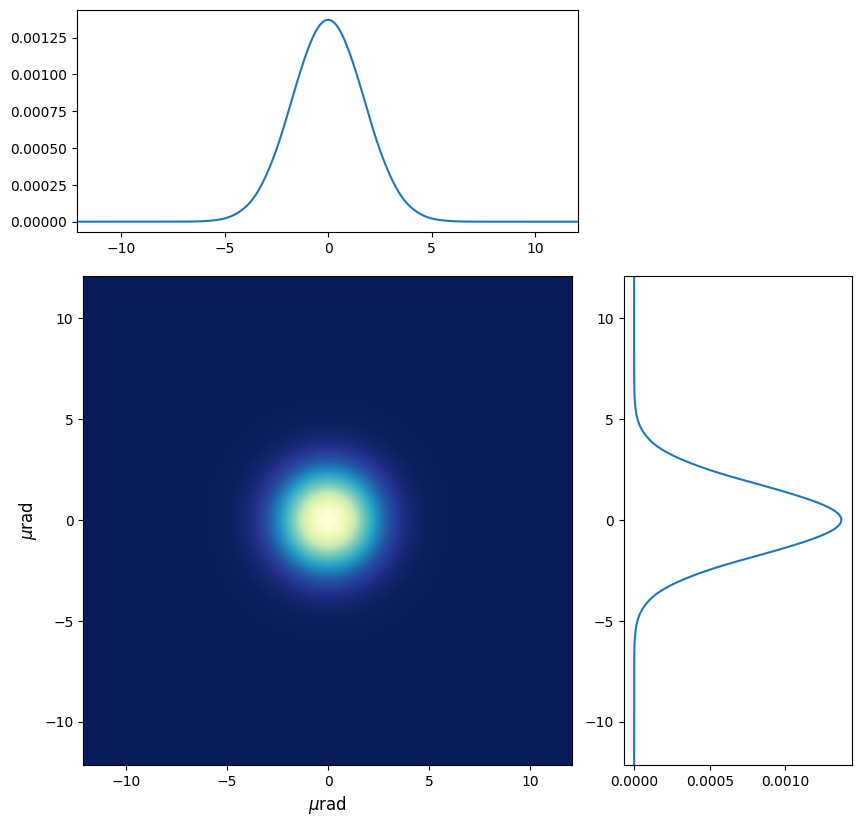

In [28]:
wpg_utils.plot_intensity_qmap(wavefront)

In [30]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
|Vertical  |1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


## Estimate focus position
Use the classical lense formula
$$
\frac{1}{z_O} + \frac{1}{z_I} = \frac{1}{f}
$$
where $z_O$ and $z_I$ are the distances from the object to the lense and distance from lense to image, respectively.

**Solution**:
With $z_O = 100\,\text{m}$ and $f = 27.2 m$, rearranging the lens formula yields


In [28]:
z_O = 100
f = 27.2
z_I = 1./(1/f - 1/z_O)
z_I

37.362637362637365

In [35]:
md(f"The image position is at {numpy.round(z_I, 1)} m behind the lense")

The image position is at 37.4 m behind the lense

# Propagate for another 37.4 m

In [36]:
crl_to_screen = optical_elements.Drift(_L=37.4, _treat=1)

In [37]:
crl_to_screen_pp = optical_elements.Use_PP(semi_analytical_treatment=1)

In [38]:
beamline.append(crl_to_screen, crl_to_screen_pp)

In [39]:
# Reset the wavefront.
wavefront = copy.deepcopy(photon_source.data)

In [40]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
propagate_wavefront(wavefront, beamline)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 27.202097743745966
	Fy = 27.202097743745966
	arTr = array of size 2004002
	extTr = 1
	input_parms = {'type': 'crl', 'focalPlane': 3, 'refractiveIndex': 5.3304712513701975e-06, 'attenuationLength': 0.00594067304452888, 'shape': 1, 'horizontalApertureSize': 0.005, 'verticalApertureSize': 0.005, 'radius': 0.0058, 'numberOfLenses': 20, 'wallThickness': 8e-05, 'horizontalCenterCoordinate': 0.0, 'verticalCenterCoordinate': 0.0, 'voidCenterCoordinates': None, 'initialPhotonEnergy': 0, 'finalPhotonPnergy': 0, 'horizontalPoints': 1001, 'verticalPoints': 1001}
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1001
		ny = 1001
		xFin = 0.0027500000000000003
		xStart = -0.0027500000000000003
		yFin = 0.0027500000000000003
		yStart = -0.0027500000000000003
		zStart = 0
	
	
Optical Element: 

R-space
(400,) (400,)
FWHM in x = 3.822e-05 m.
FWHM in y = 3.822e-05 m.


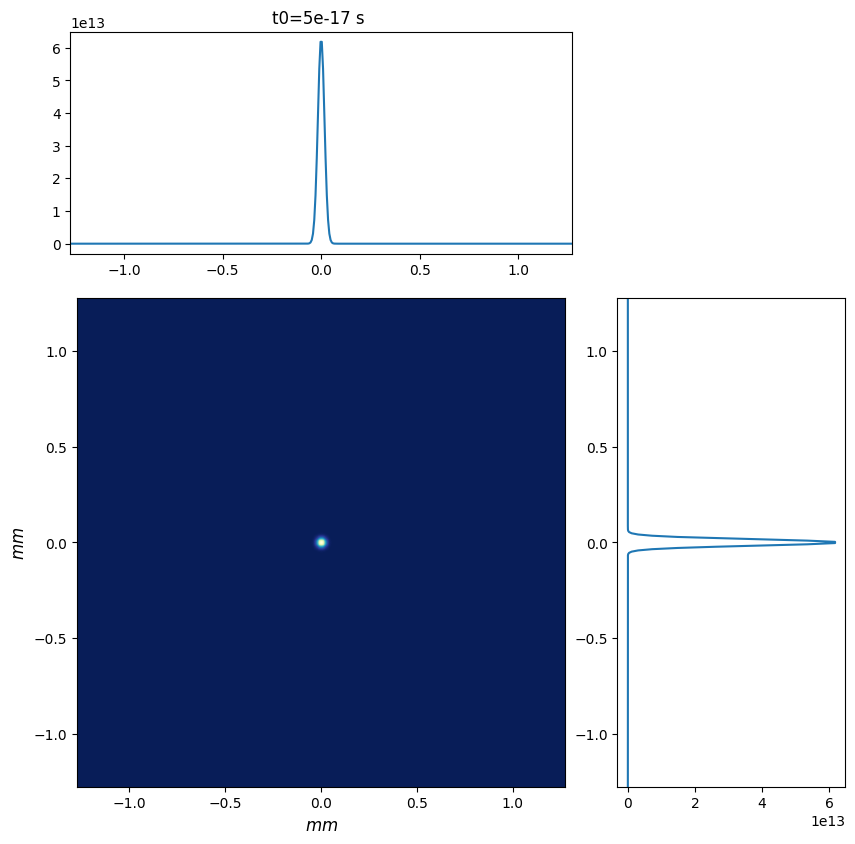

In [41]:
wpg_utils.plot_intensity_map(wavefront)

**Tasks**
1. Optimize the focus: Measure the focus FWHM at 10 positions around the chosen screen distance of 37.4 m. 
1. Plot the focus FWHM against distance from CRL.
1. Revisit the analytical expression for the beam waist of a Gaussian beam as a function of distance from focus. 
1. Fit the beam waist expression to your data and compare the fitted focus FWHM to the analytical solution and the numerical data.

In [43]:
!git add crl_focus.ipynb

In [46]:
!git commit -a -m "Update CRL focus notebook:\nFinalize propagation to screen,\n Estimate focus from lens formua,\n Add tasks"

[simple_diffraction 340e2ba] Update CRL focus notebook:\nFinalize propagation to screen,\n Estimate focus from lens formua,\n Add tasks
 2 files changed, 1094 insertions(+), 1 deletion(-)
 create mode 100644 examples_diffraction/crl_focus.ipynb
